## 1 Import Libraries
ส่วนนำเข้าเครื่องมือที่จำเป็นสำหรับการจัดการข้อมูลและพล็อตกราฟ

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# ตั้งค่าการแสดงผลกราฟ
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2 Load & Preprocess Functions
ฟังก์ชันสำหรับอ่านและทำความสะอาดข้อมูลจากแต่ละไฟล์ (จัดการวันที่, เปลี่ยนชื่อคอลัมน์, แปลงประเภทข้อมูล)

In [2]:
def load_gold():
    """โหลดราคาทองคำและแปลงวันที่"""
    df = pd.read_csv('gold_history_updated.csv')
    
    # ใช้วันที่สากลจาก col 'datetime' ถ้ามี หรือแปลงจาก 'date'
    if 'datetime' in df.columns:
        df['date'] = pd.to_datetime(df['datetime'], errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        
    # เลือกราคาขายออก (gold_bar_sell หรือ gold_sell)
    col_price = 'gold_bar_sell' if 'gold_bar_sell' in df.columns else 'gold_sell'
    df['gold'] = pd.to_numeric(df[col_price], errors='coerce')
    
    return df[['date', 'gold']].dropna().drop_duplicates('date', keep='last')

def load_btc():
    """โหลดราคา Bitcoin"""
    df = pd.read_csv('bitcoin_history_updated.csv')
    df['date'] = pd.to_datetime(df['date'])
    df['btc'] = pd.to_numeric(df['btc_price'], errors='coerce')
    return df[['date', 'btc']].dropna().drop_duplicates('date', keep='last')

def load_fx():
    """โหลดอัตราแลกเปลี่ยน (USD/THB)"""
    # ใช้ไฟล์ exchange_rate_updated.csv เพราะข้อมูลครบถ้วนกว่า
    df = pd.read_csv('exchange_rate_updated.csv')
    df['date'] = pd.to_datetime(df['date'])
    df['fx'] = pd.to_numeric(df['mid_rate'], errors='coerce')
    return df[['date', 'fx']].dropna().drop_duplicates('date', keep='last')

def load_set():
    """โหลดดัชนีหุ้นไทย (SET Index)"""
    df = pd.read_csv('set_index_updated.csv')
    df['date'] = pd.to_datetime(df['date'])
    # ลบลูกน้ำออกถ้ามี (เช่น 1,600.50)
    if df['Close'].dtype == 'object':
        df['Close'] = df['Close'].str.replace(',', '')
    df['set'] = pd.to_numeric(df['Close'], errors='coerce')
    return df[['date', 'set']].dropna().drop_duplicates('date', keep='last')

def load_oil():
    """โหลดราคาน้ำมัน (ตัวแทน: U.S. Diesel No.2)"""
    df = pd.read_csv('petroleum_data_updated.csv')
    # Filter เฉพาะ U.S. Diesel เพื่อใช้เป็น Benchmark
    mask = (df['area-name'] == 'U.S.') & (df['product-name'].str.contains('No 2 Diesel', case=False))
    df = df[mask].copy()
    
    # แปลง Monthly (YYYY-MM) เป็น Date (YYYY-MM-01)
    df['date'] = pd.to_datetime(df['period'].astype(str) + '-01', errors='coerce')
    df['oil'] = pd.to_numeric(df['value'], errors='coerce')
    return df[['date', 'oil']].dropna().drop_duplicates('date', keep='last')

def load_cpi():
    """โหลดดัชนีราคาผู้บริโภค (CPI)"""
    df = pd.read_csv('CPI_clean_updated.csv')
    # Filter เฉพาะ 'รวมทุกรายการ' (code 0)
    df = df[df['code'].astype(str).str.match(r'^0+$')]
    df['date'] = pd.to_datetime(df['date'])
    df['cpi'] = pd.to_numeric(df['cpi_index'], errors='coerce')
    return df[['date', 'cpi']].dropna().drop_duplicates('date', keep='last')

## 3 Merge Data
รวมข้อมูลทั้งหมดเข้าด้วยกันโดยใช้ date เป็นแกนกลาง และเติมข้อมูลที่หายไป (Forward Fill)

In [3]:
# 1. โหลดข้อมูลแยกแต่ละตัว
df_gold = load_gold()
df_btc = load_btc()
df_fx = load_fx()
df_set = load_set()
df_oil = load_oil()
df_cpi = load_cpi()

# 2. รวมตาราง (Merge)
dfs = [df_gold, df_btc, df_fx, df_set, df_oil, df_cpi]
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), dfs)

# 3. จัดการข้อมูลหลังรวม
df_merged = df_merged.sort_values('date')
df_merged = df_merged.ffill()  # เติมข้อมูลวันหยุดด้วยค่าก่อนหน้า
df_merged = df_merged[df_merged['date'] >= '2023-01-01'].dropna() # ตัดเฉพาะช่วงที่มีข้อมูลครบ

print(f"Data Shape: {df_merged.shape}")
df_merged.head()

Data Shape: (1052, 7)


,date,gold,btc,fx,set,oil,cpi
2,2023-01-03,30450.0,16679.86,33.2294,1678.969971,4.576,100.37
3,2023-01-04,30450.0,16863.24,33.2294,1673.250000,4.576,100.37
4,2023-01-05,30250.0,16836.74,33.2294,1663.859985,4.576,100.37
5,2023-01-06,30150.0,16951.97,33.2294,1673.859985,4.576,100.37
6,2023-01-07,30250.0,16955.08,33.2294,1673.859985,4.576,100.37


## 4 Correlation Heatmap
สร้าง Heatmap เพื่อดูความสัมพันธ์ระหว่างตัวแปร

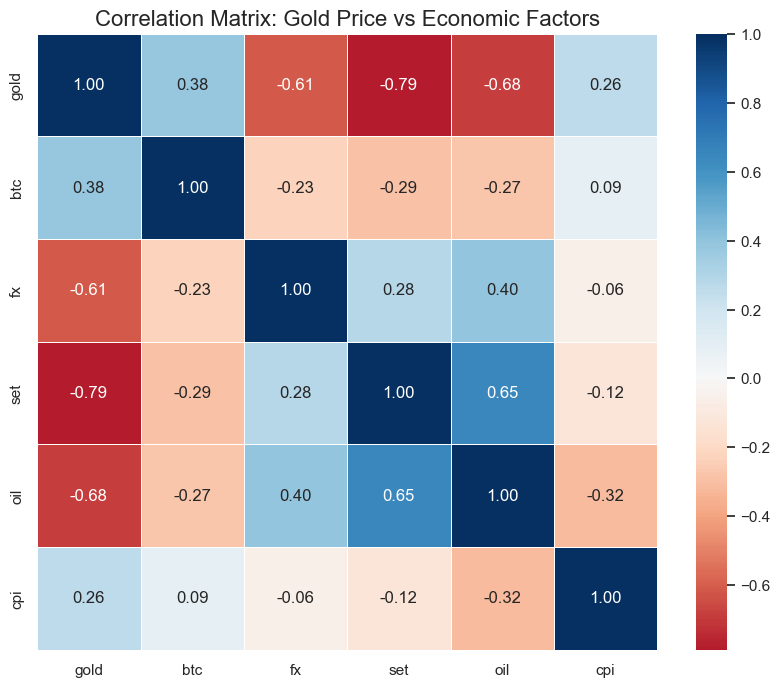

In [7]:
plt.figure(figsize=(10, 8))
corr_matrix = df_merged.drop('date', axis=1).corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Gold Price vs Economic Factors', fontsize=16)
plt.savefig('corr_matrix_gold_vs_ecofactor.png')
plt.show()

## 5 Market Trends (Normalized)
กราฟเปรียบเทียบแนวโน้ม โดยปรับสเกลข้อมูลทุกตัวให้อยู่ในช่วง 0-1

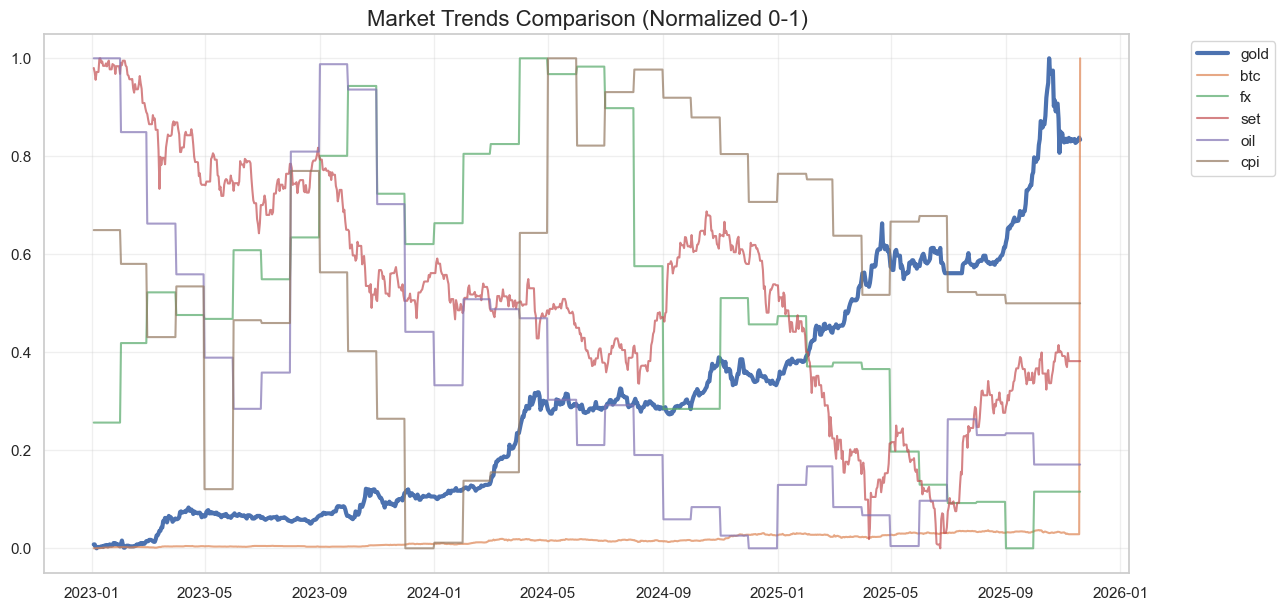

In [8]:
# Normalize ข้อมูลเพื่อพล็อตกราฟเทียบกัน
df_plot = df_merged.set_index('date')
df_norm = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

plt.figure(figsize=(14, 7))
for col in df_norm.columns:
    # เน้นเส้น Gold ให้หนาหน่อย
    linewidth = 3 if col == 'gold' else 1.5
    alpha = 1 if col == 'gold' else 0.7
    plt.plot(df_norm.index, df_norm[col], label=col, linewidth=linewidth, alpha=alpha)

plt.title('Market Trends Comparison (Normalized 0-1)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout
plt.savefig('market_trends.png')
plt.show()

## 6 Scatter Plot Analysis
เจาะลึกความสัมพันธ์เฉพาะคู่ที่น่าสนใจ (เช่น Gold vs Bitcoin)

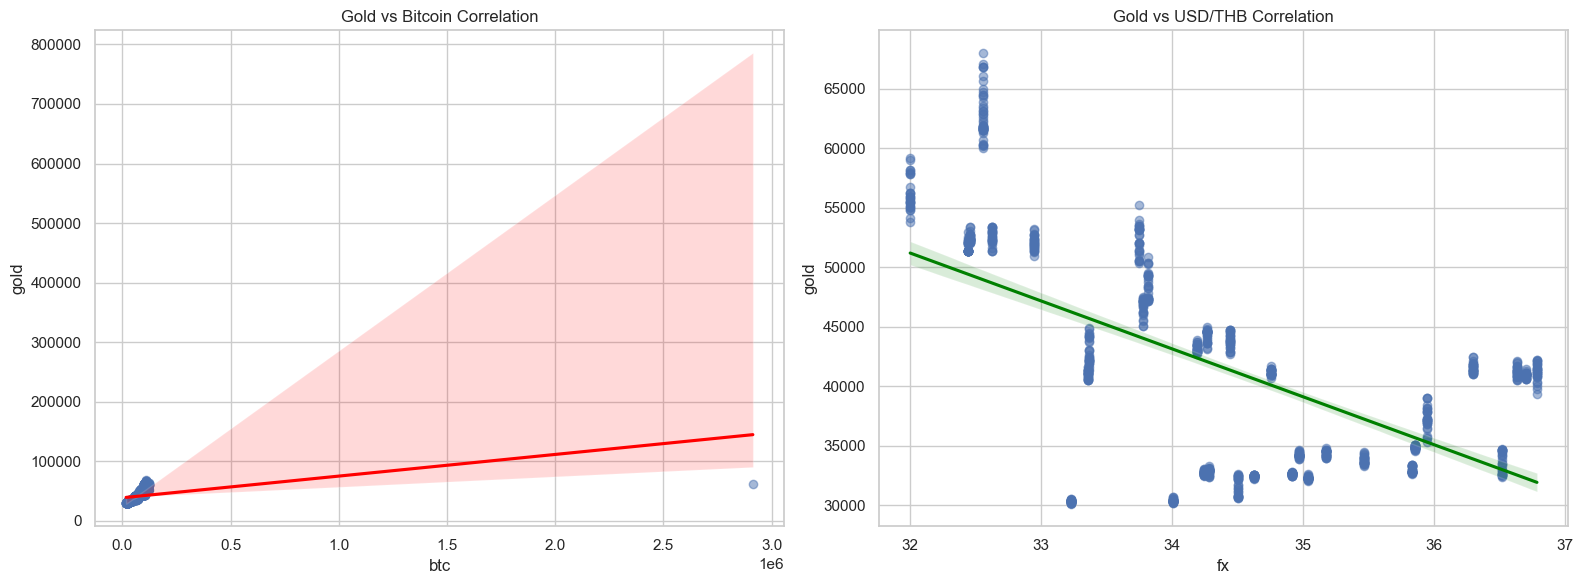

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Gold vs Bitcoin
sns.regplot(ax=axes[0], x='btc', y='gold', data=df_merged, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0].set_title('Gold vs Bitcoin Correlation')

# Plot 2: Gold vs USD/THB (FX)
sns.regplot(ax=axes[1], x='fx', y='gold', data=df_merged, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
axes[1].set_title('Gold vs USD/THB Correlation')

plt.tight_layout()
plt.savefig('gold_btc_fx_scatter.png')
plt.show()